# Case study: Lorenz attractor
#### Authors: Guillaume Tauzin <guillaume.tauzin@epfl.ch>, Matteo Caorsi <m.caorsi@l2f.ch>
##### License: TBD


This notebook contains a full TDA pipeline to analyse the transitions of the Lorenz system to a chaotic regime from the stable one and viceversa.

The first step consists in importing the *giotto* library.

In [1]:
# Import the giotto library
import giotto as go
import giotto.datasets as ds
import giotto.time_series as ts
import giotto.graphs as gr
import giotto.diagram as diag
import giotto.homology as hl
import numpy as np
import pandas as pd
import datetime as dt
import sklearn as sk
from giotto.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

import plotly.graph_objs as gobj
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Setting up the Lorenz attractor simulation

In the next block we set up all the parameters of the Lorenz system and we define also the instants at which the regime (stable VS chaotic) changes.

In [35]:
max_duration = 10000
transition_list = [0.037500000000000006, 0.047, 0.0625, 0.077, 0.10350000000000001, 0.1275, 0.1585, 0.1615, 
                  0.1685, 0.2215, 0.23, 0.23700000000000002, 0.2515, 0.2715, 0.3, 0.30750000000000005, 0.3385, 
                  0.36350000000000005, 0.388, 0.40449999999999997, 0.41950000000000004, 0.4225, 0.4515, 
                  0.46950000000000003, 0.506, 0.5405, 0.542, 0.5825, 0.5825, 0.6144999999999999, 0.635, 0.66, 
                  0.677, 0.6845, 0.685, 0.729, 0.749, 0.769, 0.777, 0.8075, 0.8310000000000001, 0.833, 0.864, 
                  0.8674999999999999, 0.882, 0.903, 0.9395, 0.94, 0.974, 0.99]

# Method to generate a solution of the Lorenz system
lorenz_attractor = ds.LorenzDataset(initial_conditions=(1, -10, 10), sigma=10., beta=8./3., rho_min=5, rho_max=15,
                     transition_list=transition_list, number_transitions=25, transition_duration=100,
                     time_step=0.01, max_duration=max_duration, mean_noise=0., std_deviation_noise=0.0)
lorenz_attractor.run()

In [36]:
# Plotting the trajectories of the Lorenz system
trace = gobj.Scatter3d(x=lorenz_attractor.x_, y=lorenz_attractor.y_, z=lorenz_attractor.z_, mode='markers',
                       marker=dict(size=4, color=list(range(max_duration)),
                       colorscale='Viridis', opacity=0.8))

data = [trace]
layout = gobj.Layout(margin=dict(l=0, r=0, b=0, t=0))

figure = gobj.Figure(data=data, layout=layout)
iplot(figure)

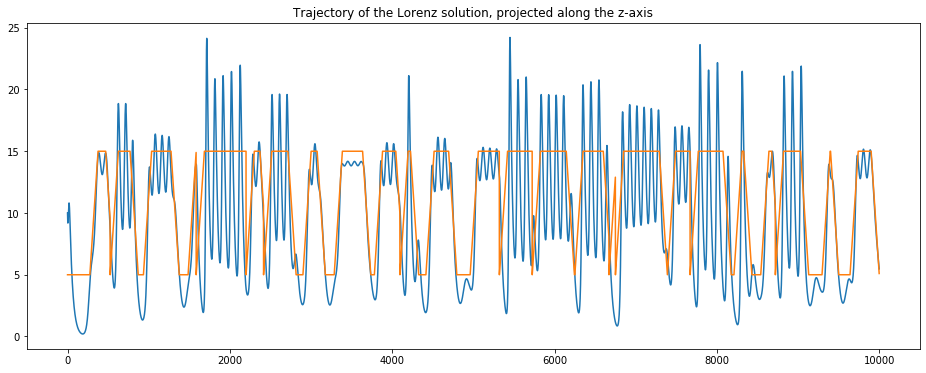

In [38]:
X = lorenz_attractor.z_
y = lorenz_attractor.rho_

# Plotting the Lorenz system
fig = plt.figure(figsize=(16,6))
plt.plot(X)
plt.plot(y)
plt.title('Trajectory of the Lorenz solution, projected along the z-axis')
plt.show()

# Resampling the time series

It is important to find the correct time scale at which key signals take place. Here we propose one possible resampling period: *10h*. Recall that the unit time is *1h*. The resampler method is used to perform the resampling.

In [5]:
period = 10
periodicSampler = ts.Resampler(period=period)

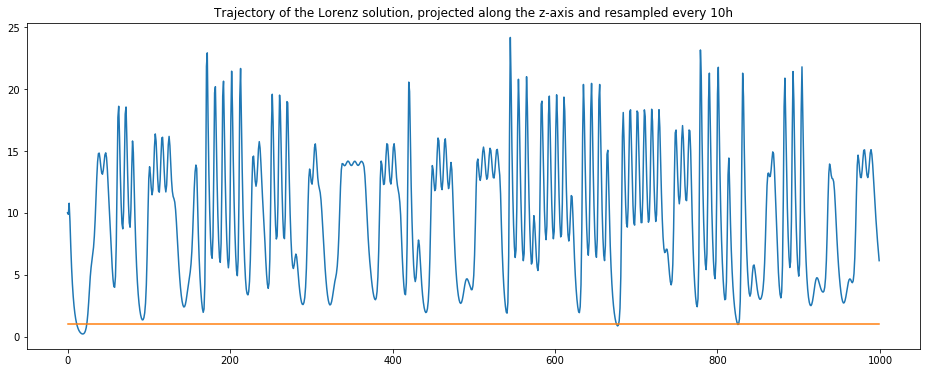

In [6]:
periodicSampler.fit(X)
X_sampled, y_sampled = periodicSampler.transform_resample(X, y)

fig = plt.figure(figsize=(16,6))
plt.plot(X_sampled)
plt.plot(y_sampled)
plt.title('Trajectory of the Lorenz solution, projected along the z-axis and resampled every 10h')
plt.show()

In [7]:
# Steps of the Pipeline
steps = [
    ('sampling', ts.Resampler(period=period)),
    ('classifier', RandomForestClassifier(n_estimators=100))
]

# Sklearn Pipeline
pipeline = Pipeline(steps)

pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('sampling', Resampler(period=10)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

# Takens Embedding

In order to obtain meaningful topological features from a time series, we use a delayed-time embedding technique, invented by F. Takens in the late sixties.
The idea is simple: given a time series X(t), one can extract a sequence of vectors of the form X_i := [(X(t_i)), X(t_i + 2 tau), ..., X(t_i + M tau)].
The difference between t_i and t_i-1 is called *stride*; the numbers M and tau are optimized authomatically in this example (they can be set by the user if needed).
    
The *outer window* allows us to apply Takens embedding locally on a certain interval rather than over the whole time series. The result of this procedure is therefore a time series of point clouds with possibly interesting topologies.


In [8]:
embedding_dimension = 10
embedding_time_delay = 3
embedder = ts.TakensEmbedder(parameters_type='search', dimension=embedding_dimension, 
                             time_delay=embedding_time_delay, n_jobs=-1)

In [9]:
embedder.fit(X)
embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

print('Optimal embedding time delay based on mutual information: ', embedder_time_delay)
print('Optimal embedding dimension based on false nearest neighbors: ', embedder_dimension)

Optimal embedding time delay based on mutual information:  3
Optimal embedding dimension based on false nearest neighbors:  5


In [10]:
X_embedded, y_embedded = embedder.transform_resample(X_sampled, y_sampled)

In [11]:
window_width = 40
window_stride = 5
sliding_window = ts.SlidingWindow(width=window_width, stride=window_stride)
sliding_window.fit(X_embedded, y_embedded)

X_windows, y_windows = sliding_window.transform_resample(X_embedded, y_embedded)

In [12]:
print(X_windows.shape, y_windows.shape)

(190, 40, 5) (190,)


In [13]:
window_number = 3

In [14]:
# Plotting Takens embedding of the first outer window
window = X_windows[window_number]
trace = gobj.Scatter3d(x=window[:, 0], y=window[:, 1], z=window[:, 2], mode='markers',
                     marker=dict(size=4, color=list(range(window.shape[0])),
                     colorscale='Viridis', opacity=0.8))

data = [trace]
layout = gobj.Layout(margin=dict(l=0, r=0, b=0, t=0))

figure = gobj.Figure(data=data, layout=layout)
iplot(figure)

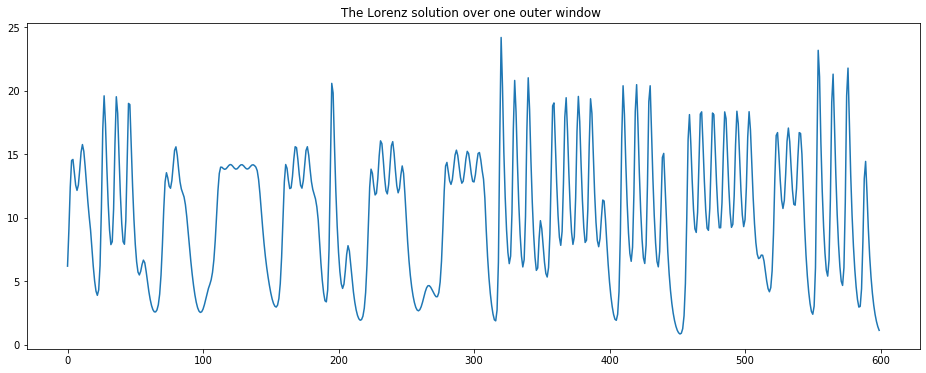

In [15]:
# Plotting the time series associated to the above point cloud. 
# Notice the two periodicities corresponding to the loops in the embedding
fig = plt.figure(figsize=(16,6))
plt.plot(X_sampled[(window_number*window_stride)*embedder_time_delay*embedder_dimension:
                   (window_number*window_stride + window_width)*embedder_time_delay*embedder_dimension])
plt.title('The Lorenz solution over one outer window ')
plt.show()

# Persistence diagram
The topological information of the correlation metric is synthesised in the persistent diagram. The horizonral axis corresponds to the moment in which an homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.
The generators of the homology groups (at given rank) are colored differently.

In [16]:
homology_dimensions = [0, 1 ,2]
persistenceDiagram = hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=100, 
                                            homology_dimensions=homology_dimensions, n_jobs=-1)
persistenceDiagram.fit(X_windows)
X_diagrams = persistenceDiagram.transform(X_windows, y_windows)

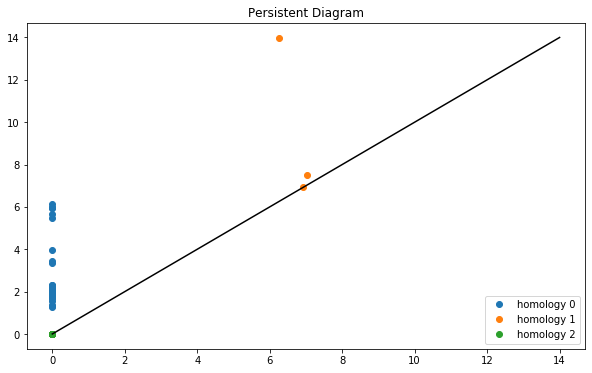

In [17]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: X_diagrams[dimension][window_number] for dimension in homology_dimensions }

for dimension in homology_dimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o',label='homology '+ str(dimension))
plt.title('Persistent Diagram')
plt.legend(loc='lower right')
plt.plot([0, 14], [0, 14], color='k')
plt.show()

# Distances among diagrams

In this section we show how to compute distances among persistent diagrams. There are many notions of distances: here we use the *bottleneck distance* as an example.

We stress that the *i-th* row of this matrix is the distance of the *i-th* diagram from all the others.

In [18]:
# Computing the bottleneck distance of the time series of persistent diagrams
diagramDistance = diag.DiagramDistance(metric='wasserstein', metric_params={'p': 2, 'delta': 0.1}, n_jobs=-1)
diagramDistance.fit(X_diagrams)
X_distance_W = diagramDistance.transform(X_diagrams)

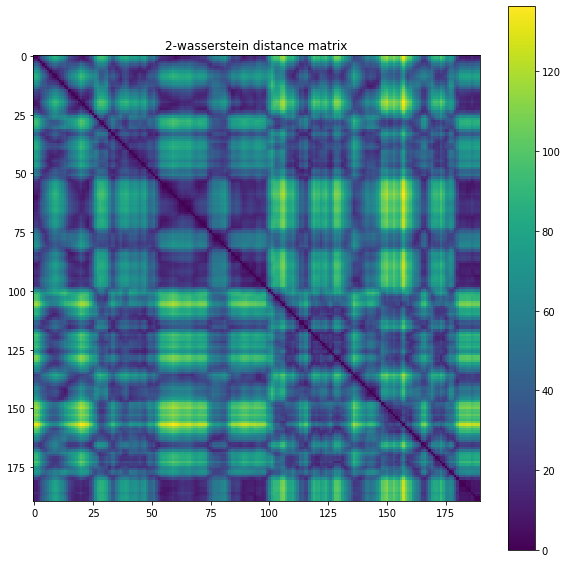

In [19]:
figure = plt.figure(figsize=(10,10))
plt.imshow(X_distance_W)
plt.colorbar()
plt.title('2-wasserstein distance matrix')
plt.show()

In [20]:
# We change metric: we compute the landscape distance among the diagrams 
diagramDistance = diag.DiagramDistance(metric='landscape', metric_params={'p': 2, 'n_layers':1, 'n_sampled_values':1000}, 
                                       n_jobs=-1)
diagramDistance.fit(X_diagrams)
X_distance_L = diagramDistance.transform(X_diagrams)

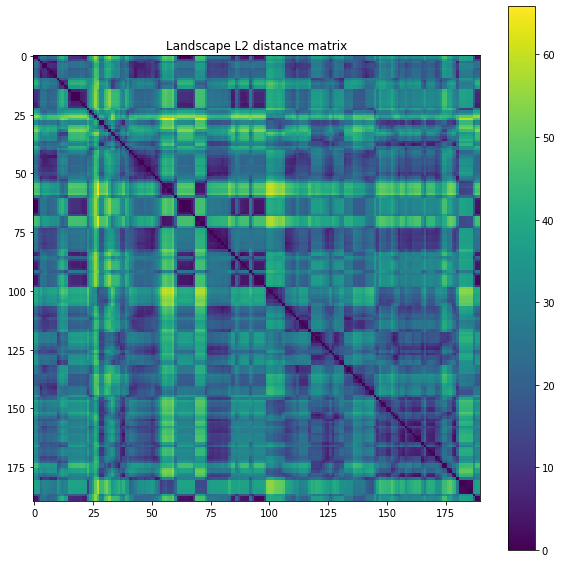

In [21]:
# Plot of the landascape L2 distance between persistent diagrams 
figure = plt.figure(figsize=(10,10))
plt.imshow(X_distance_L)
plt.colorbar()
plt.title('Landscape L2 distance matrix')
plt.show()

# Adding gaussian noise

It is claimed in the literature that TDA is robust with respect to noise. Let us then add noise to the system and redo the previous analysis and see what changes! 

In [22]:
lorenzAttractor.stdDeviationNoise = 0.3
lorenzAttractor.run()

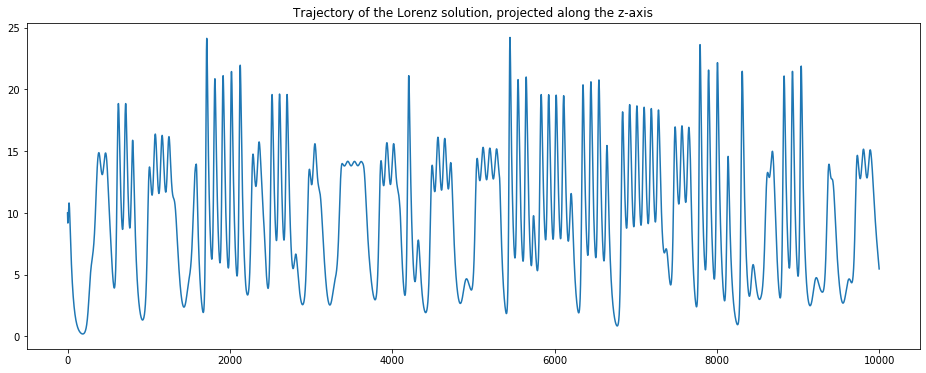

In [23]:
X_noisy = lorenzAttractor.z_
y = np.ones((X.shape[0],))

# Plotting the Lorenz system
fig = plt.figure(figsize=(16,6))
plt.plot(X_noisy)
plt.title('Trajectory of the Lorenz solution, projected along the z-axis')
plt.show()

# Scikit-learn *Pipeline*
One of the advantages of our giotto library is the compatibility with scikit-learn. It is possible to set up a full pipeline such as the one above in a few lines. We will show how in the next section.



In [24]:
# Steps of the Pipeline
steps = [
    ('sampling', ts.Resampler(period=period)),
    ('embedding', ts.TakensEmbedder(parameters_type='search', dimension=embedding_dimension, 
                                    time_delay=embedding_time_delay, n_jobs=-1)),
    ('window', ts.SlidingWindow(width=window_width, stride=window_stride)),
    ('diagrams', hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=100, 
                                            homology_dimensions=homology_dimensions, n_jobs=-1))
]

# Sklearn Pipeline
pipeline = Pipeline(steps)

In [25]:
# Running the pipeline
pipeline.fit(X_noisy)
X_diagrams_noisy = pipeline.transform(X_noisy)

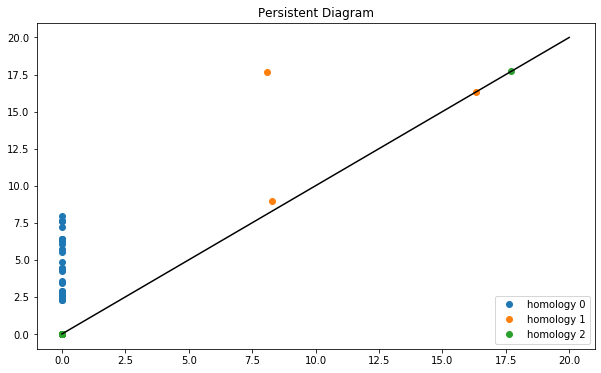

In [26]:
# Plotting the final persistent diagram of one outer window
fig = plt.figure(figsize=(10,6))
diagram = { dimension: X_diagrams_noisy[dimension][window_number] for dimension in homology_dimensions }

for dimension in homology_dimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o',label='homology '+ str(dimension))
plt.title('Persistent Diagram')
plt.legend(loc='lower right')
plt.plot([0, 20], [0, 20], color='k')
plt.show()

# Rescaling the diagram
Rescaling the diagram means normalizing the points such that their distance from the *empty diagram* is equal to one.
Once the diagram is rescaled, we can filter noise by removing all the points that are close to the diagonal.

In [27]:
diagram_scaler = diag.DiagramScaler()
diagram_scaler.fit(X_diagrams_noisy)
X_scaled_noisy = diagram_scaler.transform(X_diagrams_noisy)

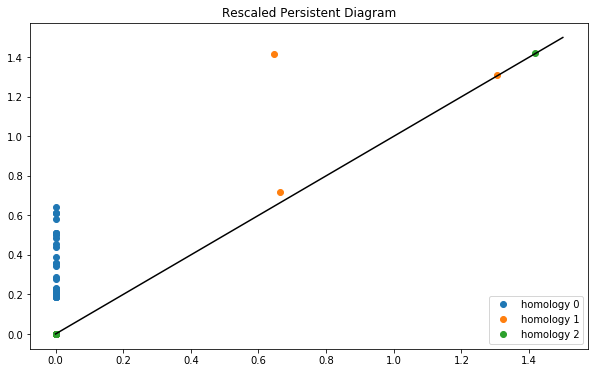

In [28]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: X_scaled_noisy[dimension][window_number] for dimension in homology_dimensions }

for dimension in homology_dimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o',label='homology '+ str(dimension))
plt.title('Rescaled Persistent Diagram')
plt.legend(loc='lower right')
plt.plot([0, 1.5], [0, 1.5], color='k')
plt.show()

# Filtering diagrams

Filtering noise from a diagram corresponds to eliminating all the homology generators whose lifespan is too short to be significant. It means equivalently that we are removing the points closer to the diagonal than a centrain threshold.

In [29]:
# Perparing the filtering transformer
diagram_filter = diag.DiagramFilter(delta=0.05, homology_dimensions={1, 2})
diagram_filter.fit(X_scaled_noisy)
X_filtered_noisy = diagram_filter.transform(X_scaled_noisy)

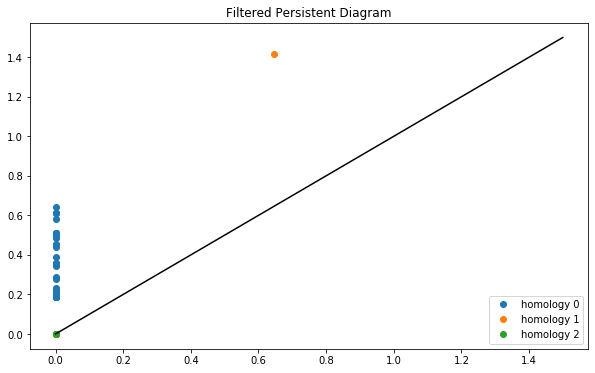

In [30]:
# Plot of the filtered diagram
fig = plt.figure(figsize=(10,6))
diagram = { dimension: X_filtered_noisy[dimension][window_number] for dimension in homology_dimensions }

for dimension in homology_dimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o',label='homology '+ str(dimension))
plt.title('Filtered Persistent Diagram')
plt.legend(loc='lower right')
plt.plot([0, 1.5], [0, 1.5], color='k')
plt.show()

In [31]:
# Wrapping up all the steps inside a scikit-learn pipeline
steps = [
    ('sampling', ts.Resampler(period=period)),
    ('embedding', ts.TakensEmbedder(parameters_type='search', dimension=embedding_dimension, 
                                    time_delay=embedding_time_delay, n_jobs=1)),
    ('window', ts.SlidingWindow(width=window_width, stride=window_stride)),
    ('diagrams', hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=100, 
                                            homology_dimensions=homology_dimensions, n_jobs=1)),
    ('diagrams_scaler', diag.DiagramScaler()),
    ('diagrams_filter', diag.DiagramFilter(delta=0.05))
]

pipeline_filter = Pipeline(steps)

In [32]:
pipeline_filter.fit(X_noisy)
X_filtered_noisy = pipeline_filter.transform(X_noisy)

In [33]:
# Plot the filtered diagram
fig = plt.figure(figsize=(10,6))
diagram = { dimension: zDiagramsFilteredPipeline_noise[dimension][window_number] for dimension in homology_dimensions }

for dimension in homology_dimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o',label='homology '+ str(dimension))
plt.title('Filtered Persistent Diagram')
plt.legend(loc='lower right')
plt.plot([0, 2], [0, 2], color='k')
plt.show()

NameError: name 'zDiagramsFilteredPipeline_noise' is not defined

<Figure size 720x432 with 0 Axes>

# New distance in the embedding space: permutations and graphs

We propose here a new way to compute distances between points in the embedding space. Instead of considering the Euclidean distance in the Takens space, we propose to build a k-nearest neightbors graph and then use the geodesic distance on such graph.

In [ ]:
kNN_graph = gr.KNeighborsGraph(n_neighbors=3, n_jobs=1)
kNN_graph.fit(X_embedded)
X_kNN = kNN_graph.transform(X_embedded[0].reshape((1, X_embedded.shape[1], -1)))

# Geodesic distance on graphs
Given the graph embedding, the natural notion of distance between vertices corresponds to the lengths of the shortest path connecting two vertices. This is also known as *graph geodesic distance*. 

In [ ]:
geodesic_distance = gr.GraphGeodesicDistance(n_jobs=1)
geodesic_distance.fit(X_kNN)
X_GeoNN = geodesic_distance.transform(X_kNN)

In [ ]:
# Plotting the geodesic distance
figure = plt.figure(figsize=(10,10))
plt.imshow(X_GeoNN[0])
plt.colorbar()
plt.title('Plot of the geodesic distance of the first outer window kNN graph')
plt.show()

# New embedding: permutations and graphs

We propose here a new way to transform the time series outer windows into graphs rather than point clouds. The idea is to create a graph whose vertices are permutation patterns and the edges exists between two vertices if the corresponding patterns happened one after the other.

In [ ]:
ordinal_rep = ts.OrdinalRepresentation(n_jobs=-1)
ordinal_rep.fit(X_windows)
X_ordinal = ordinal_rep.transform(X_windows)

In [ ]:
# Permutation embedding of the first outer window
window = X_ordinal[window_number]
trace = gobj.Scatter3d(x=window[:, 0], y=window[:, 1], z=window[:, 2], mode='markers',
                       marker=dict(size=4, color=list(range(window.shape[0])),
                       colorscale='Viridis', opacity=0.8))

data = [trace]
layout = gobj.Layout(margin=dict(l=0, r=0, b=0, t=0))

figure = gobj.Figure(data=data, layout=layout)
iplot(figure)

# Synthetic features extracted from topology

One can use persistent diagrams as he pleases. Here we show one way of extracting summary information from the time-series of diagrams: the *permutation entropy*. The entropy is computed by estimating a probability based on teh counting how many permutation patterns appear along the time series within the outer window.

In [ ]:
# Computing permutation entropy
permutation_entropy = ts.Entropy(n_jobs=1)
permutation_entropy.fit(X_ordinal)
X_entropy = permutation_entropy.transform(X_ordinal)

In [ ]:
# Plot the sampled Lorenz solution, projected along the z-axis
fig = plt.figure(figsize=(16,6))
plt.plot(X_sampled)
plt.title('Resampled solution of the Lorenz attractor projected along the z-axis')
plt.show()

In [ ]:
# Plot of the permutation entropy time-series
fig = plt.figure(figsize=(16,6))
plt.plot(X_entropy)
plt.title('Permutation entropy')
plt.show()

# Computing graph distances between the time series of graphs
The procedure we have developed associateds to each outer window a graph. This graph is a subgraph of the full permutation graph. The distance among subgraphs is then defined via the geodesic distance.

In [ ]:
transition_graph = gr.TransitionGraph(n_jobs=1)
transition_graph.fit(X_ordinal)
X_transition = transition_graph.transform(X_ordinal)

In [ ]:
# Computing geodesic distance between subgraph inside the universal graph
geodesic_distance = gr.GraphGeodesicDistance(n_jobs=1)
geodesic_distance.fit(X_transition)
X_geodesic = geodesic_distance.transform(X_transition)

In [ ]:
# Plot of the geodesci distance between the time series of subgraphs
figure = plt.figure(figsize=(10,10))
plt.imshow(X_geodesic[window_number])
plt.colorbar()
plt.title('Geodesic graph distance between subgraphs.')
plt.show()